# imports

In [2]:
# imports and config
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
!pip3 install pysindy
import pysindy as ps
import scipy.stats as stats
from scipy import signal
import requests
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 4.9 MB/s 


0


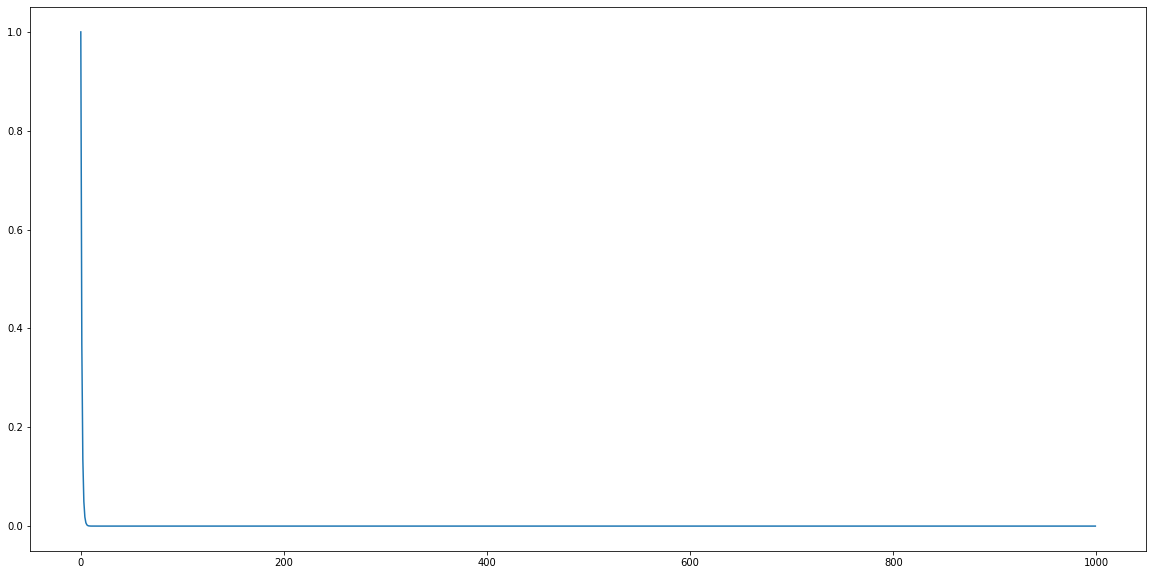

In [3]:
plt.figure(figsize=(20,10))
t = np.arange(1000)
y = stats.gamma.pdf(t, 1, scale=1, loc = 0)
plt.plot(y)
print(np.sum(np.isnan(y)))
#print(y)

# grab data from usgs rest api

In [4]:
grand_rapids_mi_id = "04119000"
croton_mi_id = "04121970"
palmer_mi_id = "04058200"
sidnaw_mi_id = "04040500"
newburg_mo_id = "06932000"
show_low_az_id = "09496500"
sedona_az_id = "09504420"
valle_az_id = "09404104"
bisbee_az_id = "09470700"
myakka_head_fl_id = "02299950"
fort_meade_fl_id = "02294898"

# handpicked for small contributing area
boxelder_creek_nemo_sd = "06422500"
grizzly_bear_creek_keystone_sd = "06403850" # (only has stage, not discharge)
grace_coolidge_creek_custer_sd = "06404998"
boggy_creek_enid_ok = "07160280" # only stage, no discharge
north_boggy_creek_ok = "07160290" # only stage no discharge
skeleton_creek_ok = "07160350"
rio_ruidoso_nm = "08386505"

# mallets_creek_mi_id = "04174518" (doesn't include precip)
mill_creek_ok = "07331200"
# olmos and salado could have longer records
olmos_ck_tx = "08177700"
salado_ck_tx = "08178700"
san_pedro_ck_tx = "08178500"
big_fossil_ck_tx = "08048800"
walnut_ck_tx = "08049700"
langham_ck = "08072760"
bundick = "08014800"
baker_ck = "02303205"
# below are from around tampa bay fl
braden_riv = "02300033"
north_archie = "02301740"
st_joe_ck = "02308950"
long_branch = "02307780"
alligator_ck = "02307674"




sites = [grand_rapids_mi_id,croton_mi_id,palmer_mi_id,
         sidnaw_mi_id,newburg_mo_id, show_low_az_id, 
         sedona_az_id, valle_az_id, bisbee_az_id, 
         myakka_head_fl_id, fort_meade_fl_id,
         boxelder_creek_nemo_sd, grizzly_bear_creek_keystone_sd,
         grace_coolidge_creek_custer_sd, boggy_creek_enid_ok,
         north_boggy_creek_ok, skeleton_creek_ok, rio_ruidoso_nm,
         mill_creek_ok, olmos_ck_tx, salado_ck_tx, san_pedro_ck_tx, big_fossil_ck_tx,
         walnut_ck_tx, langham_ck, bundick, baker_ck, braden_riv, north_archie, st_joe_ck,
         long_branch, alligator_ck]


print("number of sites: ")
print(len(sites))
# some sites (sidnaw) have had equipment failures which causes errors in parsing the data
#sites = [grand_rapids_mi_id,croton_mi_id,palmer_mi_id,newburg_mo_id, show_low_az_id, sedona_az_id, valle_az_id, bisbee_az_id, myakka_head_fl_id, fort_meade_fl_id]

start_date = "2022-07-15" # use the same for all
end_date = "2022-10-15"
#end_date = str(datetime.today().strftime("%Y-%m-%d"))
#parameters = "00045,00060,00065" # rainfall, discharge, and gage height
#parameters = "00045, 00065" # rainfall and gage height


site_data = dict.fromkeys(sites)
for site_id in sites:
  request_string = str("https://waterservices.usgs.gov/nwis/iv/?format=rdb,1.0&sites="+site_id+"&startDT="+start_date+"&endDT="+end_date+"&parameterCd=00045,00065&siteStatus=all")
  print(request_string)
  meta = pd.read_csv(request_string, skiprows=14,nrows=10,sep='\t')
  #print(meta)
  site_name = meta.columns[0][5:]

  data = pd.read_csv(request_string,header = [0,1],sep='\t',comment = '#').fillna(method='bfill')
  if (site_id == "08386505"): # rio ruidoso is weird for some reason
    data = pd.read_csv(request_string,header = [0,1],sep='\t',comment = '#').fillna(method='pad')
  #print(data)


  #for_sindy = data.to_numpy()[:,[4,6,8]].astype(float)
  for_sindy = data.to_numpy()[:,[4,6]].astype(float) # just rainfall and stage
  #print(for_sindy)
  for_sindy[:,1] = for_sindy[:,1] - np.min(for_sindy[:,1])
  #print(for_sindy)
  '''
  # peak retaining smoothing of discharge
  # width and prominence will need to be tuned
  peaks = signal.find_peaks(np.array(for_sindy[:,1]),distance = 100,width=50)
  #print("number of peaks = ", len(peaks[0]))
  # window length will need to be tuned
  smoothed = signal.savgol_filter(for_sindy[:,1],window_length=15,polyorder=3)
  franken = np.zeros(len(smoothed))
  for i in np.arange(0,len(for_sindy[:,1])):
    if any(np.abs(i - peaks[0]) <= int(10)): 
      # if we're within x samples of a peak, keep the original data
      franken[i] = for_sindy[:,1][i]
    else: # otherwise, give us the smoothed value
      franken[i] = smoothed[i]

  #discharge = signal.savgol_filter(franken,window_length=3,polyorder=2) 
  #minimal smoothing to avoid discontinuous transitions


  # try smoothing the whole thing (don't try to retain peaks separately)
  # if you make the window too long, you'll make the system anticipatory, don't do that
  #discharge = signal.savgol_filter(for_sindy[:,1],window_length=5,polyorder=1)

  # use moving average data for sindy
  #for_sindy[:,1] = discharge

  '''
  # try smoothing the whole thing (don't try to retain peaks separately)
  # if you make the window too long, you'll make the system anticipatory, don't do that
  for_sindy[:,1] = signal.savgol_filter(for_sindy[:,1],window_length=5,polyorder=1)
  site_data[site_id] =[site_name, data,for_sindy]

  fig, ax1 = plt.subplots(figsize=(20,10))
  plt.title(site_name,fontsize=20)
  ax2 = ax1.twinx()
  l1 = ax1.plot(for_sindy[:,0],'b',label='precip')
  l2 = ax2.plot(for_sindy[:,1],'r--',label='stage')


  #l3 = ax2.plot(discharge,'g-.',label='smoothed discharge' )
  ax1.set_ylabel("precip (in)")
  ax2.set_ylabel("stage - min(stage) (ft)")
  lns = l1+l2#+l3
  labs = [l.get_label() for l in lns]
  plt.legend(lns, labs, loc=0, fontsize=25)

  plt.show()



#print(site_data)

Output hidden; open in https://colab.research.google.com to view.

# fitting functions definition

In [5]:
def SINDY_delays_3d(shape_factors, scale_factors, loc_factors, t, forcing, response, final_run, poly_degree):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 


    feature_names.append(str("forcing" + str(shape_idx + 1)) )
  
  # SINDy
  model = ps.SINDy(
      differentiation_method= ps.SmoothedFiniteDifference(),
      feature_library=ps.PolynomialLibrary(degree=poly_degree,include_bias = False, include_interaction=False), 
      optimizer = ps.STLSQ(threshold=0), 
      feature_names = feature_names
  )

  #U = np.concatenate((np.reshape(forcing,(-1,1)), shapes) , axis=1)
  #if (any(shapes == np.inf)):
  #  print("infinite value in U")
  #U = np.nan_to_num(shapes,nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
  U = shapes
  model.fit(response,t=t,u=U)
  #model.print()
  #print("score = ",model.score(response,t=t,u=U)) # training data score

  mae = 10**6 # placeholder, shows simulation diverged or wasn't final run
  rmse = 10**6
  simulated = np.ones(shape=(len(response[1:]),1))*np.mean(response)
  if (final_run): 
    
    print("number of lines:")
    print(len(shape_factors))
    plt.figure(figsize=(20,10))
    plt.plot(U)
    plt.title("final input transformations")
    plt.show()
    '''
    plt.figure(figsize=(5,5))
    plt.title("input transformation parameters")
    plt.scatter(loc_factors, shape_factors)
    plt.xlabel("location")
    plt.ylabel("shape")
    plt.show()
    '''

    model.print(precision=5)
    print("score = ",model.score(response,t=t,u=U)) # training data score

    try: # in case simulation diverges
      y = np.reshape(response,(-1,1)) # to match simulation results dimension
      simulated = model.simulate([response[1]],t=t,u=U)

      fig, ax1 = plt.subplots(figsize=(20,10))
      ax2 = ax1.twinx()
      plt.title(str("polynomial degree = "+ str(poly_degree)))

      line1 = ax1.plot(t[1:],y[1:],'r-.',label='measurements')
      line2 = ax1.plot(t[1:],simulated[:len(t)-1],'g--',label='SINDy')
      ax1.set_xlabel(r'Time ($min$)')
      ax1.set_ylabel(r'response magnitude')
      ax1.set_ylim([min(0,min(y)),1.2*max(y)])

      line3 = ax2.plot(t[1:],forcing[1:],'b',label='forcing')
      ax2.set_ylabel("forcing intensity")

      line4 = ax2.plot(t[1:], shapes[1:] * ( np.max(forcing) / np.max(shapes  ) ) , 'k--', label='transformed forcing (scaled)', alpha=0.35)
      
      lns = line1+line2+line3+line4
      labs = [l.get_label() for l in lns]
      plt.legend(lns, labs, loc=0,ncol=3)


      plt.show()
      
      mae = np.mean(np.abs(simulated[:len(t)-1]-y[1:])) # mean absolute error
      print("Simulation MAE = ", mae)
      rmse = np.sqrt(np.mean((simulated[:len(t)-1]-y[1:])**2)) # root mean squared error
      print("Simulation RMSE = ", rmse)


    except:
      print("Simulation diverged.")


    


  return [model.score(response,t=t,u=U), model, mae, rmse, t[1:], simulated[:len(t)-1] , response[1:] , forcing[1:] , U]

# takes np array X and assumes the zeroeth column is the forcing
def optimize_lag_shapes(polyorder, target, init_num_lines, max_num_lines, X,max_iter):
  results = list()

  rates_of_change = abs(np.diff(X[:,target]))
  biggest_movers = np.flip(np.argsort(rates_of_change))
  maxes = np.array([biggest_movers[0]])
  if (maxes[0] < 1):
    maxes[0] = 1 # lower bound shape at 1

  # if a close neighbor is already selected, don't want that to be a starting point
  for index in range(0,len(biggest_movers)):
    if ( (abs(biggest_movers[index] - maxes) > int(len(X) / 1000*init_num_lines)).all()   ): 
      # more than some fraction of the total length apart
      # using init_num_lines strikes a balance between starting evenly spaced 
      # and starting all clustered on the steep regions
      if (biggest_movers[index] < 1):
        maxes = np.append(maxes,1) 
      else:
        maxes = np.append(maxes,float(biggest_movers[index]))
    if (len(maxes) >= max_num_lines):
      break

  previous_best = 0

  shape_factors = np.array([])
  scale_factors = np.array([])
  loc_factors = np.array([])
  speeds =  list([1000,200,50,10, 5,2, 1.1, 1.05, 1.01, 1.001])
  
  for num_lines in range(init_num_lines,max_num_lines):
    #print(num_lines)
    #speed = 6.4 # how far we'll jump around initially
    speed_idx = 0
    speed = speeds[speed_idx]

    if (len(shape_factors) == 0):  # if we're starting right now

      
      #shape_factors = maxes[0:init_num_lines]
      # start assuming immediate impact
      shape_factors = np.ones(shape=(init_num_lines,1))
      scale_factors = np.ones(shape = shape_factors.shape)
      loc_factors = np.zeros(shape = shape_factors.shape)

      
    else:
      # start dull
      #sharp_cand = maxes[num_lines]
      # start assuming immeidate impact
      sharp_cand = 1
      delay_cand = 1
      loc_cand = 0

      shape_factors = np.append(shape_factors, sharp_cand)
      scale_factors = np.append(scale_factors, delay_cand)
      loc_factors = np.append(loc_factors, loc_cand)

    # changed prev model to true for verbose output
    prev_model = SINDY_delays_3d(shape_factors, scale_factors, loc_factors, np.arange(0,len(X)), X[:,0], X[:,target],False, polyorder )

    print("\nInitial model:\n")
    print("score")
    print(prev_model[0])
    print("shape factors")
    print(shape_factors)
    print("scale factors")
    print(scale_factors)
    print("location factors")
    print(loc_factors)
    print("")

    for iterations in range(0,max_iter ):
      tuning_line = iterations % num_lines

      sooner_locs = np.array(loc_factors)
      sooner_locs[tuning_line-1] = float(loc_factors[tuning_line-1] - speed*len(X)/10**4  )
      if ( sooner_locs[tuning_line-1] < 0):
        sooner = np.zeros(len(prev_model))
      else:
        sooner = SINDY_delays_3d(shape_factors ,scale_factors ,sooner_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      
      later_locs = np.array(loc_factors)
      later_locs[tuning_line-1] = float ( loc_factors[tuning_line-1]  +   1.01*speed*len(X)/10**4 )
      later = SINDY_delays_3d(shape_factors , scale_factors,later_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      shape_up = np.array(shape_factors)
      shape_up[tuning_line-1] = float ( shape_factors[tuning_line-1]*speed*1.01 )
      shape_upped = SINDY_delays_3d(shape_up , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      shape_down = np.array(shape_factors)
      shape_down[tuning_line-1] = float ( shape_factors[tuning_line-1]/speed )
      if (shape_down[tuning_line-1] < 1):
        shape_downed = np.zeros(len(prev_model)) # return a score of zero as this is illegal
      else:
        shape_downed = SINDY_delays_3d(shape_down , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )

      scale_up = np.array(scale_factors)
      scale_up[tuning_line-1] = float(  scale_factors[tuning_line-1]*speed*1.01 )
      scaled_up = SINDY_delays_3d(shape_factors , scale_up, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      scale_down = np.array(scale_factors)
      scale_down[tuning_line-1] = float ( scale_factors[tuning_line-1]/speed )
      scaled_down = SINDY_delays_3d(shape_factors , scale_down, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      # rounder
      rounder_shape = np.array(shape_factors)
      rounder_shape[tuning_line-1] = shape_factors[tuning_line-1]*(speed*1.01)
      rounder_scale = np.array(scale_factors)
      rounder_scale[tuning_line-1] = scale_factors[tuning_line-1]/(speed*1.01)
      rounder = SINDY_delays_3d(rounder_shape , rounder_scale, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )

      # sharper
      sharper_shape = np.array(shape_factors)
      sharper_shape[tuning_line-1] = shape_factors[tuning_line-1]/speed
      if (sharper_shape[tuning_line -1] < 1):
        sharper = np.zeros(len(prev_model)) # lower bound on shape to avoid inf
      else:
        sharper_scale = np.array(scale_factors)
        sharper_scale[tuning_line-1] = scale_factors[tuning_line-1]*speed
        sharper = SINDY_delays_3d(sharper_shape ,sharper_scale,loc_factors, 
                                  np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


    

      scores = [prev_model[0], shape_upped[0], shape_downed[0], scaled_up[0], scaled_down[0], sooner[0], later[0], rounder[0], sharper[0] ]
      #print(scores)
      if (sooner[0] >= max(scores)):
        prev_model = sooner
        loc_factors = sooner_locs
      elif (later[0] >= max(scores)):
        prev_model = later
        loc_factors = later_locs

      elif(shape_upped[0] >= max(scores)):
        prev_model = shape_upped
        shape_factors = shape_up
      elif(shape_downed[0] >=max(scores)):
        prev_model = shape_downed
        shape_factors = shape_down

      elif(scaled_up[0] >= max(scores)):
        prev_model = scaled_up
        scale_factors = scale_up
      elif(scaled_down[0] >= max(scores)):
        prev_model = scaled_down
        scale_factors = scale_down


      elif (rounder[0] >= max(scores)):
        prev_model = rounder
        shape_factors = np.array(rounder_shape)
        scale_factors = np.array(rounder_scale)
      elif (sharper[0] >= max(scores)):
        prev_model = sharper
        shape_factors = np.array(sharper_shape)
        scale_factors = np.array(sharper_scale)


      elif( (num_lines - 1) == tuning_line): # the middle was best, but it's bad, tighten up the bounds (if we're at the last tuning line)
        
        speed_idx = speed_idx + 1
        
        if (speed_idx >= len(speeds)):
          break
        speed = speeds[speed_idx]
        
        '''
        if (speed > 10):
          speed = speed*0.5 # coarse tuning
          
        elif(speed > 1.3):
          speed = speed*0.8 # fine tuning
        else:
          speed = speed*0.95 # very fine tuning
        '''
        
        print("\nprevious, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper")
        print(scores)
        print("speed")
        print(speed)
        print("shape factors")
        print(shape_factors)
        print("scale factors")
        print(scale_factors)
        print("location factors")
        print(loc_factors)
        print("iteration no:")
        print(iterations)
        print("\n")
        
        #print(scores)
        if (speed < 1):
          print("converged, max accuracy for number of lines")
          break
    
    
    final_model = SINDY_delays_3d(shape_factors, scale_factors ,loc_factors,np.arange(0,len(X)), X[:,0], X[:,target], True, polyorder )
    results.append([final_model, shape_factors, scale_factors, loc_factors])
    if ((previous_best and final_model[0] - previous_best[0] < 0.005) or ( previous_best and final_model[0] - previous_best[0] < 0.01 and final_model[2] > previous_best[2] )): 
      # marginal (less than half percent improvement) OR somewhat marginal improvement in fit and worse mae
      break # we can be done
    else:
      previous_best = final_model
  winning_model = None
  best_mae = np.Inf
  for num_lines in range(len(results)):
    if (results[num_lines][0][2] < best_mae):
      winning_model = results[num_lines]
      best_mae = results[num_lines][0][2]

  return winning_model
    
def transform_input(shape_factors, scale_factors, loc_factors,t, forcing):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

  return shapes 


# compare rainfall transformation parameters

single input transformation, linear models

In [6]:

for site in site_data:
  site_data[site] = np.append(site_data[site],np.zeros(3))
  site_data[site] = np.append(site_data[site],0)

for site in site_data:
  #print(site_data[site][2])
  #print(type(site_data[site][2][0,1]))
  #print(sum(sum(np.isnan(site_data[site][2]))))

  x_train = np.array(site_data[site][2][:int(0.9*len(site_data[site][1]))]) # first 90% of the record is for training
  x_test = np.array(site_data[site][2][int(0.9*len(site_data[site][1])):]) # the rest is for testing
  
  # smooth the discharge and height measurements (only for training, doesn't matter for testing)
  #x_train[:,1] = signal.savgol_filter(x_train[:,1],window_length=5,polyorder=3)
  #x_train[:,2] = signal.savgol_filter(x_train[:,2],window_length=5,polyorder=2)
  
  
  target = 1 # discharge, 2 would be gage height
  best_model = optimize_lag_shapes(1,1,1,2,x_train,150)

  site_data[site][3] = np.array([best_model[1],best_model[2],best_model[3]])
  site_data[site][4] = best_model[0][0]

  U = transform_input(best_model[1], best_model[2], best_model[3], np.arange(len(x_test)) , x_test[:,0]) 
  simulation = best_model[0][1].simulate([x_test[0,target]] , np.arange(len(x_test)), u=U)
  plt.figure(figsize=(20,10))
  plt.plot(x_test[1:,target],'r')
  plt.plot(simulation,'g')
  plt.title(site_data[site][0])
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [7]:
print(len(site_data))
site_params = np.zeros(shape=(len(site_data),3))
scores = np.zeros(shape = (len(site_data),1)  )
print(site_params)

site_names = list()
idx = 0
for site in site_data:
  #print(site_data[site][0])
  #print(np.reshape(site_data[site][3], (-1,)) )
  site_names.append(site_data[site][0])
  site_params[idx] = np.reshape(site_data[site][3], (-1,))
  scores[idx] = site_data[site][4]
  idx = idx+1

#print(site_params)
#print(site_names)


transformations = pd.DataFrame(index=site_names, columns = ['shape','scale','location','score', 'total_precip (in)', 'watershed area (sq miles)'])
transformations.shape = site_params[:,0]
transformations.scale=site_params[:,1]
transformations.location=site_params[:,2]
transformations.score = scores[:]


print(transformations)

32
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
                                                          shape      scale  \
USGS 04119000 GRAND RIVER AT GRAND RAPIDS, MI          1.000000   2.180313   
USGS 04121970 MUSKEGON RIVER NEAR CROTON, MI           2.112537   3.278153   
USGS 04058200 SCHWEITZER CREEK NEAR PALMER, MI         1.000000   2.193413   
USGS 04040500 STURGEON RIVER NEAR SIDNAW, MI           1.000000  12.111640   
USGS 06932000 Little Piney Creek at Newburg, MO        3.385324   0.983865   
USGS 09496500 CARRIZO CREEK NEAR SHOW LOW, AZ.         2.401394   1.083333   
USGS 09504420 OAK CREEK NEAR SEDONA, AZ                1.000000   

In [27]:
# drainage areas for each site (manually)
print(sites)
'''
grand_rapids_mi_id = "04119000": 4900
croton_mi_id = "04121970": 2313
palmer_mi_id = "04058200": 23.6
sidnaw_mi_id = "04040500": 171
newburg_mo_id = "06932000" : 200
show_low_az_id = "09496500": 439 
sedona_az_id = "09504420": 233
valle_az_id = "09404104": 1931
bisbee_az_id = "09470700": 8.74
myakka_head_fl_id = "02299950": 65.3
fort_meade_fl_id = "02294898": 480
boxelder_creek_nemo_sd = "06422500": 94.2
grizzly_bear_creek_keystone_sd = "06403850": 8.84
grace_coolidge_creek_custer_sd = "06404998": 26.8
boggy_creek_enid_ok = "07160280" : 21.7
north_boggy_creek_ok = "07160290" : 10.5
skeleton_creek_ok = "07160350": 70
rio_ruidoso_nm = "08386505": 18.3
'''
transformations['watershed area (sq miles)'].iloc[0] = 4900
transformations['watershed area (sq miles)'].iloc[1] = 2313
transformations['watershed area (sq miles)'].iloc[2] = 23.6
transformations['watershed area (sq miles)'].iloc[3] = 171
transformations['watershed area (sq miles)'].iloc[4] = 200
transformations['watershed area (sq miles)'].iloc[5] = 439
transformations['watershed area (sq miles)'].iloc[6] = 233
transformations['watershed area (sq miles)'].iloc[7] = 1931
transformations['watershed area (sq miles)'].iloc[8] = 8.74
transformations['watershed area (sq miles)'].iloc[9] = 65.3
transformations['watershed area (sq miles)'].iloc[10] = 480
transformations['watershed area (sq miles)'].iloc[11] = 94.2
transformations['watershed area (sq miles)'].iloc[12] = 8.84
transformations['watershed area (sq miles)'].iloc[13] = 26.8
transformations['watershed area (sq miles)'].iloc[14] = 21.7
transformations['watershed area (sq miles)'].iloc[15] = 10.5
transformations['watershed area (sq miles)'].iloc[16] = 70
transformations['watershed area (sq miles)'].iloc[17] = 18.3
transformations['watershed area (sq miles)'].iloc[18] = 46.8
transformations['watershed area (sq miles)'].iloc[19] = 21.2
transformations['watershed area (sq miles)'].iloc[20] = 137
transformations['watershed area (sq miles)'].iloc[21] = 43.9
transformations['watershed area (sq miles)'].iloc[22] = 52.8
transformations['watershed area (sq miles)'].iloc[23] = 62.8
transformations['watershed area (sq miles)'].iloc[24] = 24.6
transformations['watershed area (sq miles)'].iloc[25] = 120.0
transformations['watershed area (sq miles)'].iloc[26] = 27.4
transformations['watershed area (sq miles)'].iloc[27] = 25.61
transformations['watershed area (sq miles)'].iloc[28] = 6.09
transformations['watershed area (sq miles)'].iloc[29] = 0.1 # estimated, no value provided
transformations['watershed area (sq miles)'].iloc[30] = 1.25
transformations['watershed area (sq miles)'].iloc[31] = 7.01


#print(transformations)



['04119000', '04121970', '04058200', '04040500', '06932000', '09496500', '09504420', '09404104', '09470700', '02299950', '02294898', '06422500', '06403850', '06404998', '07160280', '07160290', '07160350', '08386505', '07331200', '08177700', '08178700', '08178500', '08048800', '08049700', '08072760', '08014800', '02303205', '02300033', '02301740', '02308950', '02307780', '02307674']


In [48]:
# total precip over record

for idx in range(0,32):
  transformations['total_precip (in)'].iloc[idx] = np.sum(np.nan_to_num(site_data[str(site_names[idx][5:13])][2][:,0],nan=0))


transformations['total_precip (in)'] = pd.to_numeric(transformations['total_precip (in)'])
transformations['watershed area (sq miles)'] = pd.to_numeric(transformations['watershed area (sq miles)'])

In [51]:
transformations

,shape,scale,location,score,total_precip (in),watershed area (sq miles)
"USGS 04119000 GRAND RIVER AT GRAND RAPIDS, MI",1.000000,2.180313,0.000000,0.075836,1.71,4900.00
"USGS 04121970 MUSKEGON RIVER NEAR CROTON, MI",2.112537,3.278153,3.214000,0.268076,14.37,2313.00
"USGS 04058200 SCHWEITZER CREEK NEAR PALMER, MI",1.000000,2.193413,0.000000,0.005122,3.70,23.60
"USGS 04040500 STURGEON RIVER NEAR SIDNAW, MI",1.000000,12.111640,0.000000,0.015683,31.11,171.00
"USGS 06932000 Little Piney Creek at Newburg, MO",3.385324,0.983865,8.099190,0.249898,6.44,200.00
"USGS 09496500 CARRIZO CREEK NEAR SHOW LOW, AZ.",2.401394,1.083333,0.000000,0.133320,6.77,439.00
"USGS 09504420 OAK CREEK NEAR SEDONA, AZ",1.000000,1.412883,0.000000,0.239106,8.08,233.00
"USGS 09404104 CATARACT CREEK AT REDLANDS CROSSING NEAR VALLE, AZ",2.842637,1.425019,0.000000,0.104501,4.01,1931.00
"USGS 09470700 BANNING CREEK NEAR BISBEE, AZ",1.000000,1.543526,0.000000,0.082384,31.26,8.74
"USGS 02299950 MANATEE RIVER AT SR 64 NEAR MYAKKA HEAD, FL",1.000000,18.163655,0.000000,0.551342,33.99,65.30


In [64]:
transformations.corr().iloc[0:4,4:6]
#print(transformations.corr().shape)

,total_precip (in),watershed area (sq miles)
shape,-0.221071,-0.066984
scale,0.435942,-0.124300
location,-0.171123,0.060108
score,0.516728,-0.197157


## build linreg model with total precip, watershed area, slope (if available) (figure 7)

In [ ]:
from sklearn.linear_model import LinearRegression
x = np.transpose(np.array([transformations['total_precip (in)'].values, transformations['watershed area (sq miles)'].values]).astype(float))
y = np.transpose(np.array([transformations['shape'].values, transformations['scale'].values, transformations['location'].values, transformations['score'].values]).astype(float))
target_names = ["Shape","Scale","Location","Score"]

fig, axes = plt.subplots(2,2,figsize=(20,20))


for target in range(0,4):

  reg = LinearRegression()
  reg.fit(x,y[:,target])



  equation = str(target_names[target] + ' = {:.2E}*Precip + {:.2E}*Area'.format( reg.coef_[0], reg.coef_[1]))

  axes[target//2,target%2].scatter(y[:,target],reg.predict(x))
  axes[target//2,target%2].plot([y[:,target].min(), y[:,target].max()], [y[:,target].min(), y[:,target].max()], "k--", lw=4)
  axes[target//2,target%2].set_xlabel("Actual",fontsize=15)
  axes[target//2,target%2].set_ylabel("Predicted",fontsize=15)
  axes[target//2,target%2].legend([equation,str("R^2: {r2:.3f}".format(r2=reg.score(x,y[:,target])) )   ],fontsize=17)
  axes[target//2,target%2].set_title(target_names[target],fontsize=25)

plt.tight_layout()
plt.show()


# get better rainfall data

## get DEM based on lat/lon (the national map rest api)

In [ ]:
#Visualization
!pip install rasterio
import rasterio as rio                                                                                                                  
from rasterio.plot import show  
import rasterio.mask
import matplotlib.pyplot as plt                                                                                                         

#Working with Shapefiles
!pip install geopandas
import geopandas as gpd 
!pip install fiona
import fiona

#Projections and Transformations
!pip install pyproj
from pyproj import Transformer

#Downloads
!pip install wget
import wget

https://portal.opentopography.org/apidocs/#/Public/getGlobalDem

In [ ]:
api_key = "b5b237bf91b3520f04291179f27214d6"
r = requests.get("https://portal.opentopography.org/API/globaldem?demtype=SRTMGL3&south=44&north=45&west=-81&east=-80&outputFormat=GTiff&API_Key=b5b237bf91b3520f04291179f27214d6")


In [ ]:
print(r)
print(r.headers)
print(type(r.content))


## delineate catchment (pysheds)

## get precip estimates for centroids of partitinos of the catchment 

meteostat?

or grab every actual weather station within the catchment? (that might work better)

# train the model with multiple forcing timeseries (will have to adjust sindy_3d and optimize lag shapes for that)